In [11]:
#Questions: Name a suitable unsupervised learning algorithm that can be used to divide customers into different clusters.
#Answer: K-means

import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

df = pd.read_csv("CustomerData.csv")
df.head()
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             100 non-null    object 
 1   Age                    100 non-null    int64  
 2   Gender                 100 non-null    object 
 3   City                   100 non-null    object 
 4   AnnualIncome           99 non-null     float64
 5   TotalSpent             100 non-null    int64  
 6   MonthlyPurchases       100 non-null    int64  
 7   AvgOrderValue          100 non-null    int64  
 8   AppTimeMinutes         98 non-null     float64
 9   DiscountUsage          98 non-null     object 
 10  PreferredShoppingTime  99 non-null     object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.7+ KB


In [12]:
df.isnull().sum()

CustomerID               0
Age                      0
Gender                   0
City                     0
AnnualIncome             1
TotalSpent               0
MonthlyPurchases         0
AvgOrderValue            0
AppTimeMinutes           2
DiscountUsage            2
PreferredShoppingTime    1
dtype: int64

In [13]:
# Numerical columns
df["AnnualIncome"] = df["AnnualIncome"].fillna(df["AnnualIncome"].median())
df["AppTimeMinutes"] = df["AppTimeMinutes"].fillna(df["AppTimeMinutes"].median())

# Categorical columns
df["DiscountUsage"] = df["DiscountUsage"].fillna(df["DiscountUsage"].mode()[0])
df["PreferredShoppingTime"] = df["PreferredShoppingTime"].fillna(df["PreferredShoppingTime"].mode()[0])
df.isnull().sum()


CustomerID               0
Age                      0
Gender                   0
City                     0
AnnualIncome             0
TotalSpent               0
MonthlyPurchases         0
AvgOrderValue            0
AppTimeMinutes           0
DiscountUsage            0
PreferredShoppingTime    0
dtype: int64

In [18]:
outlier_cols = [
    "AnnualIncome",
    "TotalSpent",
    "MonthlyPurchases",
    "AvgOrderValue",
    "AppTimeMinutes"
]

Q1 = df[outlier_cols].quantile(0.25)
Q3 = df[outlier_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[outlier_cols] < (Q1 - 1.5 * IQR)) |
            (df[outlier_cols] > (Q3 + 1.5 * IQR)))
df_clean = df[~outliers.any(axis=1)]


In [ ]:
print("Original dataset size:", df.shape)
print("After outlier removal:", df_clean.shape) #rows rem


Original dataset size: (100, 12)
After outlier removal: (90, 12)


In [22]:
# Remove outliers and CREATE A COPY
df_clean = df[~outliers.any(axis=1)].copy()

# Encode categorical columns safely
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["Gender", "City", "DiscountUsage", "PreferredShoppingTime"]

for col in categorical_cols:
    le = LabelEncoder()
    df_clean.loc[:, col] = le.fit_transform(df_clean[col])


In [23]:
features = [
    "Age",
    "Gender",
    "City",
    "AnnualIncome",
    "TotalSpent",
    "MonthlyPurchases",
    "AvgOrderValue",
    "AppTimeMinutes",
    "DiscountUsage",
    "PreferredShoppingTime"
]

X = df_clean[features]


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=3, random_state=42)
df_clean["Cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = df_clean.groupby("Cluster").mean(numeric_only=True)
cluster_summary


,Age,Gender,City,AnnualIncome,TotalSpent,MonthlyPurchases,AvgOrderValue,AppTimeMinutes,DiscountUsage,PreferredShoppingTime
Cluster,,,,,,,,,,
0,45.578947,0.473684,1.947368,983684.210526,618947.368421,15.421053,8957.894737,110.105263,1.421053,0.842105
1,34.634615,0.423077,3.019231,569423.076923,247307.692308,8.500000,3358.653846,66.788462,1.961538,0.365385
2,32.684211,0.526316,3.157895,280000.000000,53684.210526,2.210526,1536.842105,18.736842,0.000000,0.000000


In [25]:
cluster_names = {
    0: "High-Value Loyal",
    1: "Value-Seeking Regular",
    2: "Price-Sensitive Occasional"
}

df_clean["CustomerSegment"] = df_clean["Cluster"].map(cluster_names)


In [28]:
def assign_offer(cluster):
    if cluster == 0:
        return "Exclusive early access + Premium membership with free express delivery"
    elif cluster == 1:
        return "Festival discounts (10–15%) + Loyalty reward points"
    else:
        return "Flash sales + Coupon discounts + Free shipping on minimum order value"

df_clean["Offer"] = df_clean["Cluster"].apply(assign_offer)
df_clean.to_csv("Customer_Offers_After_Outlier_Removal.csv", index=False)

In [29]:

import pickle

pickle.dump(kmeans, open("kmeans_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))


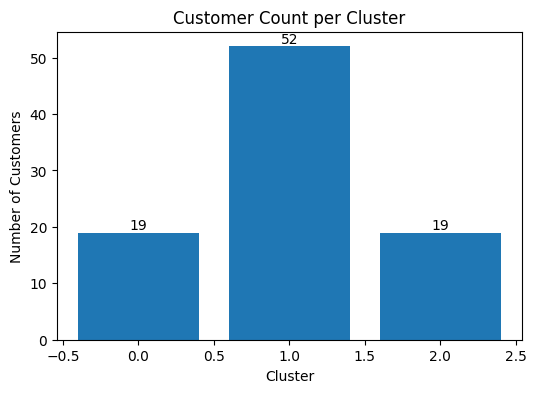

In [35]:
import matplotlib.pyplot as plt

counts = df_clean["Cluster"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values)

plt.title("Customer Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")

# Add exact numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(int(height)),
        ha="center",
        va="bottom"
    )

plt.show()


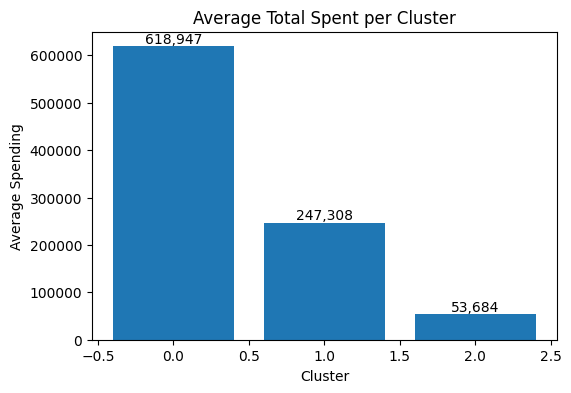

In [36]:
avg_spend = df_clean.groupby("Cluster")["TotalSpent"].mean()

plt.figure(figsize=(6, 4))
bars = plt.bar(avg_spend.index, avg_spend.values)

plt.title("Average Total Spent per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spending")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,.0f}",
        ha="center",
        va="bottom"
    )

plt.show()



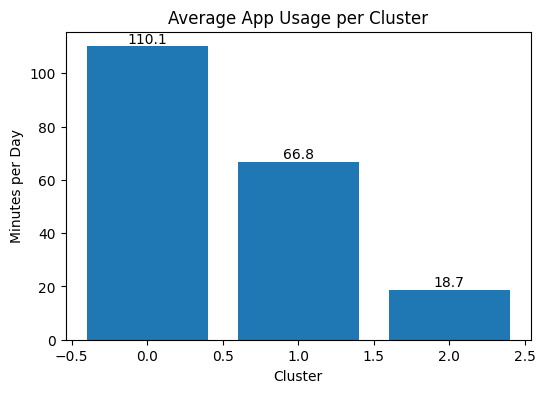

In [37]:
avg_app = df_clean.groupby("Cluster")["AppTimeMinutes"].mean()

plt.figure(figsize=(6, 4))
bars = plt.bar(avg_app.index, avg_app.values)

plt.title("Average App Usage per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Minutes per Day")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom"
    )

plt.show()


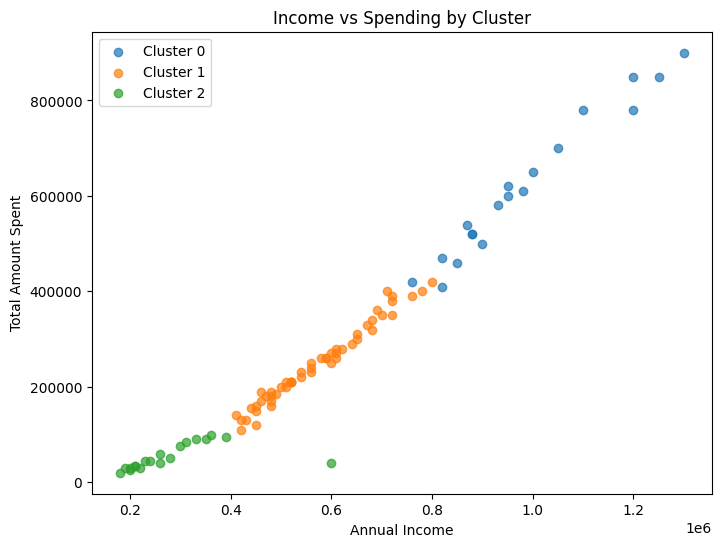

In [34]:
plt.figure(figsize=(8, 6))

for cluster in sorted(df_clean["Cluster"].unique()):
    cluster_data = df_clean[df_clean["Cluster"] == cluster]
    
    plt.scatter(
        cluster_data["AnnualIncome"],
        cluster_data["TotalSpent"],
        label=f"Cluster {cluster}",
        alpha=0.7
    )

plt.xlabel("Annual Income")
plt.ylabel("Total Amount Spent")
plt.title("Income vs Spending by Cluster")
plt.legend()
plt.show()


In [39]:
cluster_to_segment = {
    0: "High-Value Loyal",
    1: "Value-Seeking Regular",
    2: "Price-Sensitive Occasional"
}

cluster_to_offer = {
    0: "Exclusive early access to new products + Premium membership with free express delivery",
    1: "Festival discounts (10–15%) + Loyalty reward points on every purchase",
    2: "Flash sales and coupon-based discounts + Free shipping on minimum order value"
}

df_clean["CustomerSegment"] = df_clean["Cluster"].map(cluster_to_segment)
df_clean["Offer"] = df_clean["Cluster"].map(cluster_to_offer)
df_clean.to_csv("Customer_Offers_Existing_Customers.csv", index=False)
